In [ ]:
pip install darts

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel, RNNModel, BlockRNNModel, TCNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import darts.utils.timeseries_generation as tg
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood

# **Daily Energy Prodution Dataset**
In this notebook we will compare four different deep learning models using the Air Passenger Dataset. The models are:

* N-Beats

* Probabilistic RNN

* DeepTCN 

In [3]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

We test NBEATS on a daily energy generation dataset from a Run-of-river power plant, as it exhibits various levels of seasonalities

Text(0.5, 1.0, 'Hourly generation hydro run-of-river and poundage')

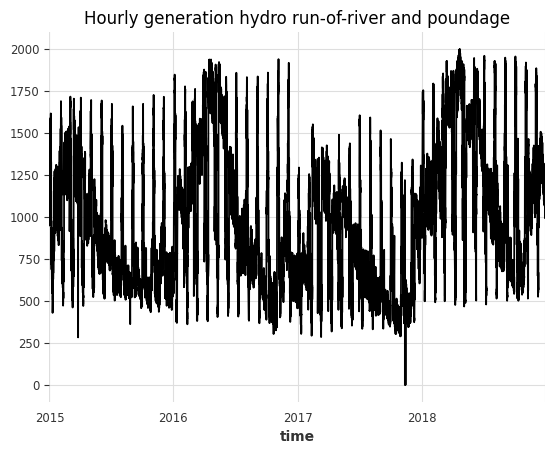

In [4]:
df = EnergyDataset().load().pd_dataframe()
df["generation hydro run-of-river and poundage"].plot()
plt.title("Hourly generation hydro run-of-river and poundage")

To simplify things, we work with the daily generation, and we fill the missing values present in the data by using the MissingValuesFiller:

Text(0.5, 1.0, 'Daily generation hydro run-of-river and poundage')

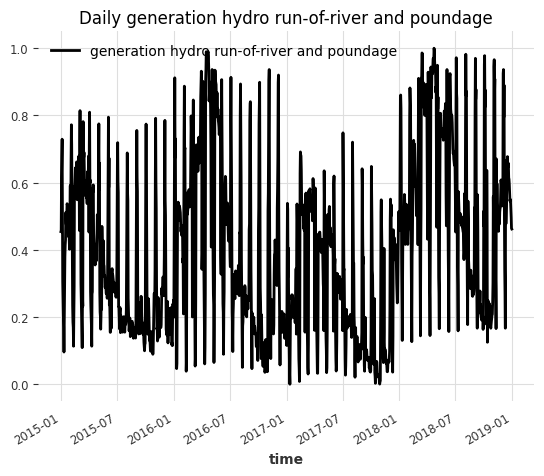

In [5]:
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_dataframe(
            df_day_avg, "time", ["generation hydro run-of-river and poundage"]
        )
    )
).astype(np.float32)
series.plot()
plt.title("Daily generation hydro run-of-river and poundage")

In [13]:
train, val = series.split_after(pd.Timestamp("20180101"))

# **N-BEATS**
The N-BEATS (Neural basis expansion analysis for interpretable time series forecasting) model is a neural network architecture designed for time series forecasting tasks. It focuses on providing interpretable and explainable forecasts by utilizing a stack of fully connected layers.

The N-BEATS model breaks down the time series into a set of basis functions, which are learned by the network. These basis functions capture different patterns and trends present in the data. The model then combines these basis functions to generate forecasts.

**Generic Architecture**
N-BEATS is a univariate model architecture that offers two configurations: a generic one and a interpretable one. The generic architecture uses as little prior knowledge as possible, with no feature engineering, no scaling and no internal architectural components that may be considered time-series-specific.

In [15]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [ ]:
model_nbeats.fit(train, val_series=val, verbose=True)

Let’s see the historical forecasts the model would have produced with an expanding training window, and a forecasting horizon of 7:

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp("20170901"),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)

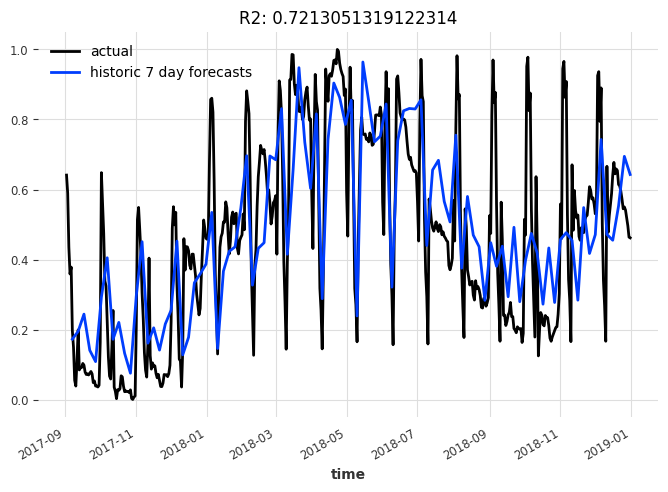

In [18]:
display_forecast(pred_series, series, "7 day", start_date=pd.Timestamp("20170901"))

**Interpretable Model**
N-BEATS offers an interpretable architecture consisting of two stacks: A trend stack and a seasonality stack. The architecture is designed so that:
* The trend component is removed from the input before it is fed into the seasonality stack
* The partial forecasts of trend and seasonality are available as separate interpretable outputs

In [19]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_interpretable_run",
)

In [ ]:
model_nbeats.fit(series=train, val_series=val, verbose=True)

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp("20170901"),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)

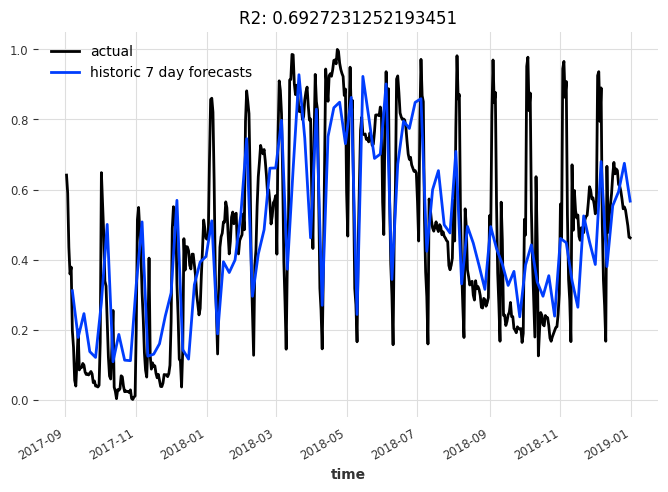

In [22]:
display_forecast(pred_series, series, "7 day", start_date=pd.Timestamp("20170901"))

In [23]:
from darts.metrics import mape
from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

mapeES = mape(val,pred_series)
maeES = mae(val,pred_series)
mseES = mse(val, pred_series)
rmseES = rmse(val, pred_series)

print(mapeES, maeES, mseES, rmseES)

48.09843301773071 0.12334846 0.023323888 0.1527216


# **Probabilistic RNN**
A Probabilistic Recurrent Neural Network (RNN) is a type of neural network architecture that incorporates probabilistic modeling techniques to generate not only point predictions but also probabilistic forecasts. Unlike deterministic models that provide single-valued predictions, probabilistic RNNs estimate a probability distribution over the possible outcomes for each time step in a time series.

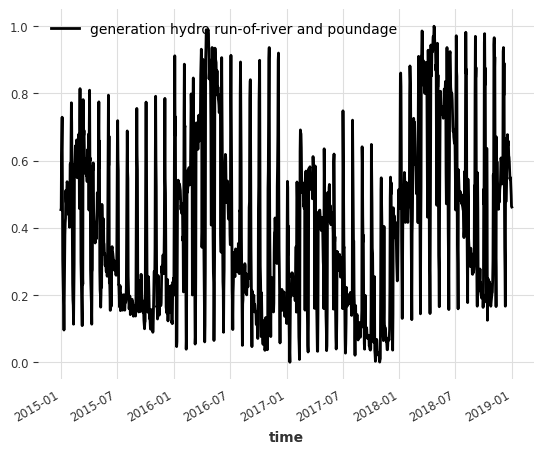

In [4]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# convert to float32
series_en = series_en.astype(np.float32)

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(
    pd.Timestamp("20170901")
)

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True, dtype=np.float32
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))

series_en_transformed.plot()

In [5]:
model_en = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=300,
    input_chunk_length=300,
    likelihood=GaussianLikelihood(),
)

In [ ]:
model_en.fit(series=train_en_transformed, future_covariates=train_day, verbose=True)

In [ ]:
backtest_en = model_en.historical_forecasts(
    series=series_en_transformed,
    future_covariates=day_series,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True,
)

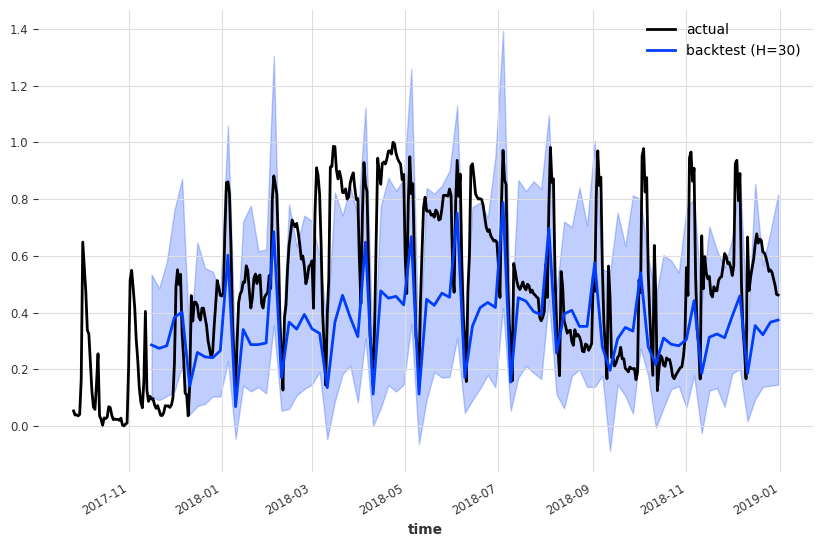

In [9]:
plt.figure(figsize=(10, 6))
series_en_transformed[1000:].plot(label="actual")
backtest_en.plot(label="backtest (H=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()

In [10]:
mapeES = mape(val_en_transformed,backtest_en)
maeES = mae(val_en_transformed,backtest_en)
mseES = mse(val_en_transformed, backtest_en)
rmseES = rmse(val_en_transformed, backtest_en)

print(mapeES, maeES, mseES, rmseES)

47.7273213464767 0.22028662439390836 0.070596252676423 0.2656995533989905


# **DeepTCN Model**

The DeepTCN (Deep Temporal Convolutional Network) is a neural network architecture designed for time series forecasting and analysis. It combines the strengths of deep learning and convolutional operations to capture temporal patterns and dependencies in sequential data.

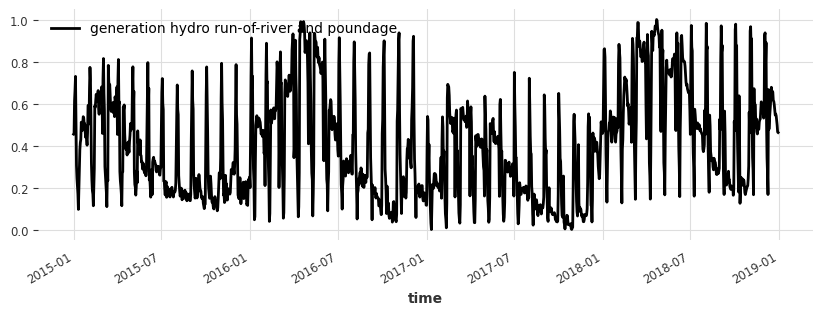

In [22]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(
    pd.Timestamp("20170901")
)

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))

plt.figure(figsize=(10, 3))
series_en_transformed.plot()

In [ ]:
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=300,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood(),
)

deeptcn.fit(series=train_en_transformed, past_covariates=train_day, verbose=True)

In [ ]:
backtest_en = deeptcn.historical_forecasts(
    series=series_en_transformed,
    past_covariates=day_series,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True,
)

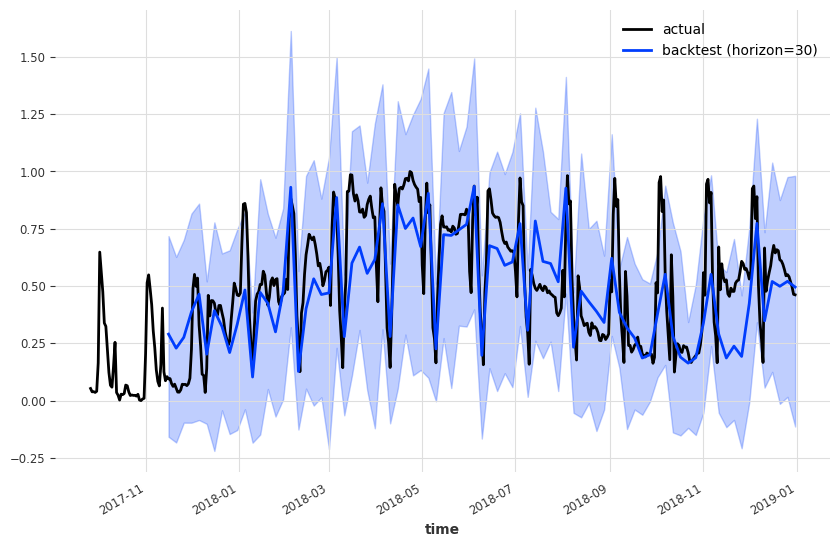

In [25]:
plt.figure(figsize=(10, 6))
series_en_transformed[1000:].plot(label="actual")
backtest_en.plot(label="backtest (horizon=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()

In [24]:
mapeES = mape(val_en_transformed,backtest_en)
maeES = mae(val_en_transformed,backtest_en)
mseES = mse(val_en_transformed, backtest_en)
rmseES = rmse(val_en_transformed, backtest_en)

print(mapeES, maeES, mseES, rmseES)

47.7273213464767 0.22028662439390836 0.070596252676423 0.2656995533989905


# Classic Statistics
In this case, as the seasonality is very high, you have to specify it manually because the methods offered by Darts cannot automatically calculate it

In [14]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode
from darts.utils.utils import SeasonalityMode

simpleExponential_model = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=SeasonalityMode.NONE)
simpleExponential_model.fit(train)
simpleExponential_pred = simpleExponential_model.predict(len(val))

holt_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.NONE)
holt_model.fit(train)
holt_pred = holt_model.predict(len(val))

holtWinters_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=365)
holtWinters_model.fit(train)
holtWinters_pred = holtWinters_model.predict(len(val))

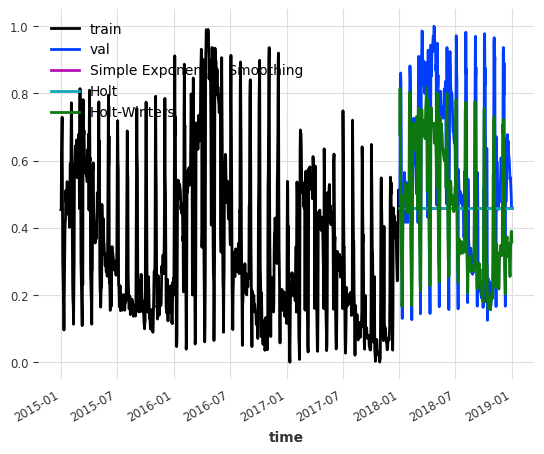

In [15]:
train.plot(label="train")
val.plot(label="val")
simpleExponential_pred.plot(label="Simple Exponential Smoothing")
holt_pred.plot(label="Holt")
holtWinters_pred.plot(label="Holt-Winters")

In [16]:
mapeES = mape(val,simpleExponential_pred)
mapeH = mape(val,holt_pred)
mapeHW = mape(val,holtWinters_pred)
print(mapeES, mapeH, mapeHW)

45.57181871126211 45.555480326754896 24.845177289942644
